<a href="https://colab.research.google.com/github/tachodril/Pytorch-Notebooks/blob/main/Digit%20Recognizer%20using%20NN%20in%20GPU/Digit_Recognizer_using_Neural_Network_in_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [2]:
#white bg for matplotlib figures
matplotlib.rcParams['figure.facecolor']='#ffffff'

In [3]:
dataset=MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(dataset)

60000

In [5]:
val_size=10000
train_size=len(dataset)-val_size

train_ds, val_ds=random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size=128

In [7]:
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_loader=DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


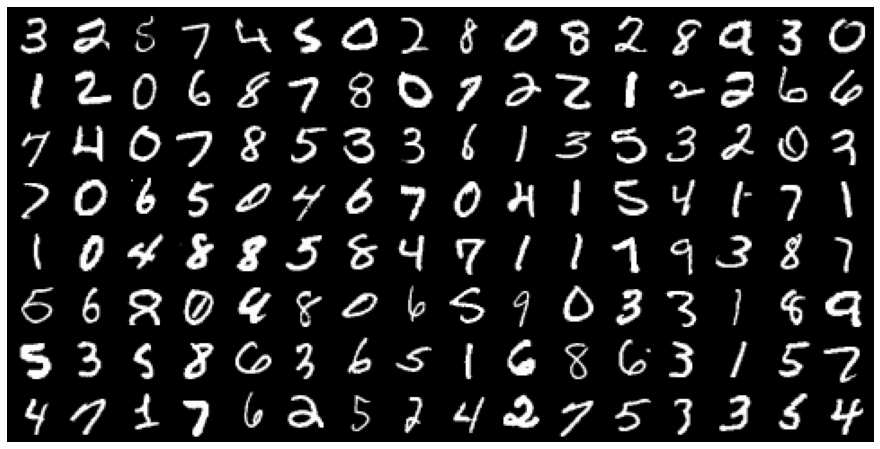

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
for images, labels in train_loader:
  print(images.shape)
  inp=images.reshape(batch_size, -1)
  print(inp.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [13]:
input_size=inp.shape[-1]
hidden_size=32
print(input_size)

784


In [11]:
layer1=nn.Linear(input_size, hidden_size)

In [12]:
layer1_out=layer1(inp)
print(layer1_out.shape)

torch.Size([128, 32])


In [14]:
layer1_out_direct=inp@layer1.weight.t()+layer1.bias
layer1_out_direct.shape

torch.Size([128, 32])

In [17]:
torch.allclose(layer1_out, layer1_out_direct, 1e-3)

True

In [18]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [19]:
relu_out=F.relu(layer1_out)
print(torch.min(relu_out))

tensor(0., grad_fn=<MinBackward1>)


In [20]:
out_size = 10
layer2=nn.Linear(hidden_size, out_size)

In [21]:
layer2_out=layer2(relu_out)
print(layer2_out.shape)

torch.Size([128, 10])


In [22]:
F.cross_entropy(layer2_out, labels)

tensor(2.3002, grad_fn=<NllLossBackward>)

In [23]:
#now lets create the model

In [26]:
class MnistModel(nn.Module):
  def __init__(self, inp_size, hidden_size, out_size):
    super().__init__()
    self.linear1=nn.Linear(inp_size, hidden_size)
    self.linear2=nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb=xb.reshape(xb.shape[0], -1)
    out=self.linear1(xb)
    out=F.relu(out)
    out=self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out=self(images)
    loss=F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out=self(images)
    loss=F.cross_entropy(out, labels)
    acc=accuracy(out, labels)
    return ({'val_loss':loss, 'val_acc':acc})

  def validation_epoch_end(self, out):
    batch_loss=[x['val_loss'] for x in out]
    batch_acc=[x['val_acc'] for x in out]
    epoch_loss=torch.stack(batch_loss).mean()
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, res):
    print("Epoch [{}], val_loss : {:.4f}, val_acc : {:.4f}".format(epoch, res['val_loss'], res['val_acc']))

In [32]:
def accuracy(out, labels):
  _, preds=torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [33]:
inp_size = 784
hidden_size = 32
class_count = 10

In [34]:
model=MnistModel(inp_size, hidden_size, class_count)

In [35]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [36]:
# Now, we will use GPU -- Tachodril

In [37]:
torch.cuda.is_available()

True

In [38]:
device = torch.device('cpu')
if(torch.cuda.is_available()):
  device=torch.device('cuda')

In [39]:
device

device(type='cuda')

In [41]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [42]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self, dl)

In [43]:
train_loader=DeviceDataLoader(train_loader, device)
val_loader=DeviceDataLoader(val_loader, device)

In [45]:
for x,y in val_loader:
  print(x.device)
  break

cuda:0


In [52]:
def evaluate(model, val_loader):
  res=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(res)

def fit(epochs, lr, model, train_loader, val_loader, opt_fn=torch.optim.SGD):
  hist=[]
  optimizer = opt_fn(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    res=evaluate(model, val_loader)
    model.epoch_end(epoch, res)
    hist.append(res)
  return hist

In [53]:
model=MnistModel(inp_size, hidden_size, class_count)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [54]:
#before training acc and loss
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.14628906548023224, 'val_loss': 2.3021819591522217}]

In [55]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss : 0.2186, val_acc : 0.9355
Epoch [1], val_loss : 0.1697, val_acc : 0.9513
Epoch [2], val_loss : 0.1686, val_acc : 0.9475
Epoch [3], val_loss : 0.1451, val_acc : 0.9573
Epoch [4], val_loss : 0.1652, val_acc : 0.9498


In [56]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss : 0.1136, val_acc : 0.9656
Epoch [1], val_loss : 0.1118, val_acc : 0.9669
Epoch [2], val_loss : 0.1112, val_acc : 0.9658
Epoch [3], val_loss : 0.1108, val_acc : 0.9659
Epoch [4], val_loss : 0.1098, val_acc : 0.9674


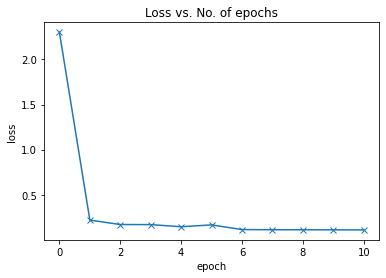

In [57]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

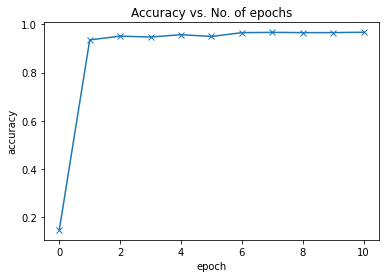

In [58]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [59]:
#lets start the testing phase
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [60]:
def predict(img, model):
  x=to_device(img.unsqueeze(0), device)
  y=model(x)
  _, pred = torch.max(y, dim=1)
  return pred[0].item()

Label: 7 , Predicted: 7


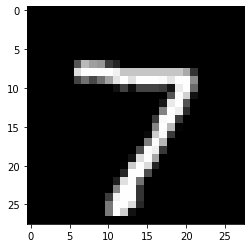

In [62]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

Label: 2 , Predicted: 2


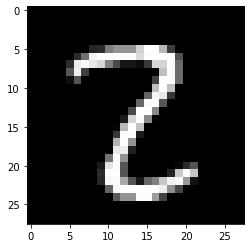

In [63]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

In [64]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
res=evaluate(model, test_loader)
res

{'val_acc': 0.9691406488418579, 'val_loss': 0.10269427299499512}

In [65]:
#perfectly done !! -- Tachodril